In [1]:
import json
from sklearn.linear_model import LinearRegression
import matplotlib
from matplotlib import lines as mlines
from matplotlib import patches as mpatches
import numpy as np
import os
import pandas as pd
from matplotlib import pyplot as plt
from scipy.stats import zscore
with open("file_paths.json", "r") as fp:
    filepaths = json.load(fp)
filepaths = {k: filepaths[k].replace("~", "/home/jclucas") for k in filepaths}
    

def agnosticize(pearson_encoding):
    shape = np.array([
        np.array(pearson_encoding[a]) for a in pearson_encoding
    ]).shape
    return(
        np.array(
            [np.array(
                pearson_encoding[a]
            ).ravel("F") for a in pearson_encoding]
        ).reshape(
            shape[0]*shape[2],
            shape[1]
        ).T
    )
    
    
def conversational_turns(sheet):
    """
    Function to count conversational turns in a 
    human-coded spreadsheet using the LENA Foundation
    definition, "(back and forth interactions between 
    a child and adult) are computed by counting the 
    number of times utterances spoken by the child or 
    adult were responded to by another person."
    
    Parameters
    ----------
    sheet: DataFrame
    
    Returns
    -------
    turn_count: int
    
    Example
    -------
    >>> import numpy as np
    >>> import pandas as pd
    >>> conversational_turns(
    ...     pd.DataFrame({
    ...         "Child": [
    ...             "spontaneous speech",
    ...             np.nan,
    ...             "no response",
    ...             np.nan,
    ...             "verbal response"
    ...         ],
    ...         "Parent": [
    ...             np.nan,
    ...             "neutral talk",
    ...             np.nan,
    ...             "open-ended question",
    ...             np.nan
    ...         ]
    ...     })
    ... )
    2
    """
    turn_count = 0
    half_turn = {
        "Child": False,
        "Parent": False,
        "Stranger ": False
    }
    stranger = sheet[
        "Stranger "
    ] if "Stranger " in sheet.columns else pd.Series(
        sheet["Child"].apply(
            lambda x: np.nan
        )
    )
    for i in range(
        len(
            sheet["Child"]
        )
    ):
        if sheet.loc[i, "Child"] in vocalizations["child"]:
            if half_turn["Parent"] or half_turn["Stranger "]:
                turn_count += 1
                half_turn["Parent"] = half_turn["Stranger "] = False
            half_turn["Child"] = True
        if sheet.loc[i, "Parent"] in vocalizations["adult"]:
            if half_turn["Child"] or half_turn["Stranger "]:
                turn_count += 1
                half_turn["Child"] = half_turn["Stranger "] = False
            half_turn["Parent"] = True
        if stranger[i] in vocalizations["adult"]:
            if half_turn["Child"] or half_turn["Parent"]:
                turn_count += 1
                half_turn["Child"] = half_turn["Stranger "] = False
            half_turn["Stranger "] = True
        if (
            sheet.loc[i, "Child"] not in vocalizations["child"]
        ) and (
            sheet.loc[i, "Parent"] not in vocalizations["adult"]
        ) and (
            stranger[i] not in vocalizations["adult"]
        ):
            half_turn["Child"] = half_turn["Parent"] = half_turn["Stranger "] = False
    return(turn_count)


def pearson_coder_format(
    human_ratings,
    LENA_ratings,
    measure,
    ursis
):
    """
    Function to take data from Multi-index DataFrames 
    and convert those data to the format
    x : array_like
        A 1-D array containing multiple variables
        and observations. Each row of x represents a
        variable, and each column a single observation
        of all those variables.
    y : array_like, optional
        An additional set of variables and observations.
        y has the same shape as x.

    Parameters
    ----------
    human_ratings: DataFrame
        Multi-index DataFrame (indices = URSI, session,
        file, in that sequence)
    
    LENA_ratings: DataFrame
        Multi-index DataFrame (indices = URSI, session,
        in that sequence)

    measure: string
        column header to collect
        
    ursis: iterable
        iterable of values for first index
        
    Returns
    -------
    formatted: dictionary
        key: string
            ursi
        value: list
            [x, y]
            x: array
            y: array
    """
    return(
        {
            ursi: [
                np.array([
                    np.mean(
                        [
                            (
                                human_ratings.loc[
                                    (ursi, "A1", f),
                                    measure
                                ] + human_ratings.loc[
                                    (ursi, "A2", f),
                                    measure
                                ] + human_ratings.loc[
                                    (ursi, "A3", f),
                                    measure
                                ]
                            ) for f in list(
                                human_ratings.loc[
                                    (ursi, "B"),
                                ].index
                            )
                        ]
                    ),
                    np.mean([
                        human_ratings.loc[
                            (ursi, "B", f),
                            measure
                        ] for f in list(
                            human_ratings.loc[
                                (ursi, "B"),
                            ].index)
                    ]),
                    np.mean([
                        human_ratings.loc[
                            (ursi, "C", f),
                            measure
                        ] for f in list(
                            human_ratings.loc[
                                (ursi, "C"),
                            ].index)
                    ])
                ]),
            np.array([
                    LENA_ratings.loc[
                        (ursi, "A"),
                        measure
                    ],
                    LENA_ratings.loc[
                        (ursi, "B"),
                        measure
                    ],
                    LENA_ratings.loc[
                        (ursi, "C"),
                        measure
                    ]
                ])
            ] for ursi in ursis
        }
    )

sessions = {
    "A1",
    "B",
    "A2",
    "C",
    "A3"
}

vocalizations = {
    "child": {
        "verbal response",
        "noise",
        "spontaneous speech"
    },
    "adult": {
        "open-ended question",
        "forced choice question",
        "yes/no question",
        "command",
        "neutral talk"
    }
}

In [2]:
LENA = pd.read_csv(
    os.path.join(
        filepaths["LENA"],
        "CPP_data.csv"
    )
)
LENA["URSI"] = LENA["URSI"].apply(
    lambda u: u.replace(
        "M04",
        "M004"
    )
)
ursis = set(LENA["URSI"].unique())
humans = {
    fp: {
        "ursi": fp[:9],
        **{sheetname: pd.read_excel(
            os.path.join(
                filepaths["humans"],
                fp
            ),
            sheet_name=sheetname
        ) for sheetname in sessions}
    } for fp in os.listdir(
        filepaths["humans"]
    ) if fp[:9] in ursis
}

In [3]:
human_ratings = pd.DataFrame({
    (ursi, session, f): {
        "Turn_Count": conversational_turns(
            humans[
                f
            ][
                session
            ]
        ),
        "Child_Voc_Count": len(
            [
                v for v in humans[
                    f
                ][
                    session
                ][
                    "Child"
                ] if v in vocalizations["child"]
            ]
        )
    } for ursi in ursis for session in sessions for f in humans if f.startswith(ursi) 
}).T.sort_index()
LENA_ratings = LENA.groupby(["URSI", "Session"]).sum()[["Turn_Count","Child_Voc_Count"]]

In [4]:
voc_counts = pearson_coder_format(
    human_ratings,
    LENA_ratings,
    "Child_Voc_Count",
    ursis
)
turns = pearson_coder_format(
    human_ratings,
    LENA_ratings,
    "Turn_Count",
    ursis
)
r = pd.DataFrame({
    ursi: {
        ("Child_Voc_Count", "Pearson's r"): np.corrcoef(
            *voc_counts[ursi]
        )[1,0],
        ("Turn_Count", "Pearson's r"): np.corrcoef(
            *turns[ursi]
        )[1,0]
    } for ursi in ursis
}).T

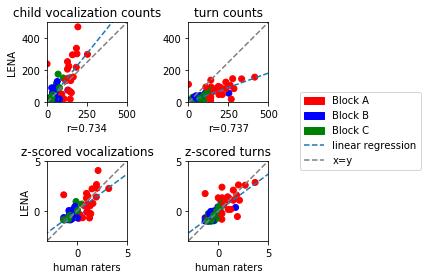

In [5]:
cvc = pearson_coder_format(human_ratings, LENA_ratings, "Child_Voc_Count", ursis)
tc = pearson_coder_format(human_ratings, LENA_ratings, "Turn_Count", ursis)
red_patch = mpatches.Patch(color='red', label='Block A')
blue_patch = mpatches.Patch(color='blue', label='Block B')
green_patch = mpatches.Patch(color='green', label='Block C')
five_hundred = np.array(range(500))
five_hundred = five_hundred.reshape(five_hundred.shape[0], 1)
cvc_model = LinearRegression().fit(*[
    x.reshape(x.shape[0], 1) for x in agnosticize(cvc)
])
z_cvc_model = LinearRegression().fit(*[
    x.reshape(x.shape[0], 1) for x in [zscore(c) for c in agnosticize(cvc)]
])
turns_model = LinearRegression().fit(*[
    x.reshape(x.shape[0], 1) for x in agnosticize(turns)
])
z_turns_model = LinearRegression().fit(*[
    x.reshape(x.shape[0], 1) for x in [zscore(c) for c in agnosticize(turns)]
])
lr = mlines.Line2D(
    five_hundred,
    (five_hundred*cvc_model.coef_+cvc_model.intercept_).reshape(
        five_hundred.shape[0],
        1
    ),
    linestyle="dashed",
    label="linear regression"
)
xy = mlines.Line2D(
    five_hundred,
    five_hundred,
    color="grey",
    linestyle="dashed",
    label="x=y"
)
fig1, f1_axes = plt.subplots(ncols=3, nrows=2)
for ursi in cvc:
    x=cvc[ursi][0]
    y=cvc[ursi][1]
    f1_axes[0][0].scatter(x, y, c=['red', 'blue', 'green'])
    tx=tc[ursi][0]
    ty=tc[ursi][1]
    f1_axes[0][1].scatter(tx, ty, c=['red', 'blue', 'green'])
f1_axes[1][0].set_xlabel("human raters")
f1_axes[0][0].set_ylabel("LENA")
f1_axes[0][0].set_title("child vocalization counts")
f1_axes[0][0].set_xlim((0, 500))
f1_axes[0][0].set_ylim((0, 500))
f1_axes[0][0].plot(
    five_hundred,
    (five_hundred*cvc_model.coef_+cvc_model.intercept_).reshape(
        five_hundred.shape[0],
        1
    ),
    linestyle="dashed",
    label="linear regression"
)
f1_axes[0][0].plot(
    five_hundred,
    five_hundred,
    "grey",
    linestyle="dashed"
)
f1_axes[0][0].set_aspect(1)
f1_axes[0][0].plot(list(np.polynomial.Polynomial.fit(*agnosticize(cvc),1)))
f1_axes[1][1].set_xlabel("human raters")
f1_axes[1][0].set_ylabel("LENA")
f1_axes[0][1].set_title("turn counts")
f1_axes[0][1].set_xlim((0, 500))
f1_axes[0][1].set_ylim((0, 500))
f1_axes[0][1].plot(
    five_hundred,
    (five_hundred*turns_model.coef_+turns_model.intercept_).reshape(
        five_hundred.shape[0],
        1
    ),
    linestyle="dashed"
)
f1_axes[0][1].plot(
    five_hundred,
    five_hundred,
    "grey",
    linestyle="dashed"
)
f1_axes[0][1].set_aspect(1)
f1_axes[0][0].set_xlabel("r={0:.3f}".format(np.corrcoef(agnosticize(cvc))[1,0]))
f1_axes[0][1].set_xlabel("r={0:.3f}".format(np.corrcoef(agnosticize(turns))[1,0]))
f1_axes[1][0].scatter(zscore(agnosticize(cvc)[0]), zscore(agnosticize(cvc)[1]), c=['red', 'blue', 'green'])
f1_axes[1][1].scatter(zscore(agnosticize(turns)[0]), zscore(agnosticize(turns)[1]), c=['red', 'blue', 'green'])
f1_axes[1][0].set_xlim((-3, 5))
f1_axes[1][0].set_ylim((-3, 5))
f1_axes[1][1].set_xlim((-3, 5))
f1_axes[1][1].set_ylim((-3, 5))
f1_axes[1][0].plot(
    five_hundred-250,
    ((five_hundred-250)*z_cvc_model.coef_+z_cvc_model.intercept_).reshape(
        five_hundred.shape[0],
        1
    ),
    linestyle="dashed"
)
f1_axes[1][0].plot(
    five_hundred-250,
    five_hundred-250,
    "grey",
    linestyle="dashed"
)
f1_axes[1][1].plot(
    five_hundred-250,
    ((five_hundred-250)*z_turns_model.coef_+z_turns_model.intercept_).reshape(
        five_hundred.shape[0],
        1
    ),
    linestyle="dashed"
)
f1_axes[1][1].plot(
    five_hundred-250,
    five_hundred-250,
    "grey",
    linestyle="dashed"
)
f1_axes[1][0].set_title("z-scored vocalizations")
f1_axes[1][1].set_title("z-scored turns")
f1_axes[1][0].set_aspect(1)
f1_axes[1][1].set_aspect(1)
f1_axes[0][2].axis("off")
f1_axes[1][2].axis("off")
fig1.tight_layout()
f1_axes[0][2].legend(handles=[red_patch, blue_patch, green_patch, lr, xy], bbox_to_anchor=(1.2,0.2))
fig1.savefig("LENAvsHumans.png", dpi=600)

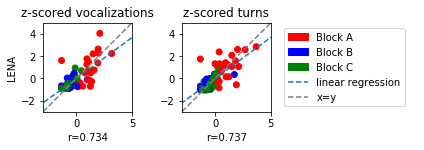

In [6]:
fig1, f1_axes = plt.subplots(ncols=3, nrows=1)
f1_axes[0].set_xlabel("human raters")
f1_axes[0].set_ylabel("LENA")
f1_axes[0].set_xlabel("r={0:.3f}".format(np.corrcoef(agnosticize(cvc))[1,0]))
f1_axes[1].set_xlabel("r={0:.3f}".format(np.corrcoef(agnosticize(turns))[1,0]))
f1_axes[0].scatter(zscore(agnosticize(cvc)[0]), zscore(agnosticize(cvc)[1]), c=['red', 'blue', 'green'])
f1_axes[1].scatter(zscore(agnosticize(turns)[0]), zscore(agnosticize(turns)[1]), c=['red', 'blue', 'green'])
f1_axes[0].set_xlim((-3, 5))
f1_axes[0].set_ylim((-3, 5))
f1_axes[1].set_xlim((-3, 5))
f1_axes[1].set_ylim((-3, 5))
f1_axes[0].plot(
    five_hundred-250,
    ((five_hundred-250)*z_cvc_model.coef_+z_cvc_model.intercept_).reshape(
        five_hundred.shape[0],
        1
    ),
    linestyle="dashed"
)
f1_axes[0].plot(
    five_hundred-250,
    five_hundred-250,
    "grey",
    linestyle="dashed"
)
f1_axes[1].plot(
    five_hundred-250,
    ((five_hundred-250)*z_turns_model.coef_+z_turns_model.intercept_).reshape(
        five_hundred.shape[0],
        1
    ),
    linestyle="dashed"
)
f1_axes[1].plot(
    five_hundred-250,
    five_hundred-250,
    "grey",
    linestyle="dashed"
)
f1_axes[0].set_title("z-scored vocalizations")
f1_axes[1].set_title("z-scored turns")
f1_axes[0].set_aspect(1)
f1_axes[1].set_aspect(1)
f1_axes[2].legend(handles=[red_patch, blue_patch, green_patch, lr, xy], loc=7)
f1_axes[2].set_aspect(1)
f1_axes[2].axis("off")
fig1.tight_layout()
fig1.savefig("LENAvsHumans_z_only.png", dpi=600)

In [7]:
np.corrcoef(agnosticize(turns))

array([[1.        , 0.73747545],
       [0.73747545, 1.        ]])

In [8]:
np.corrcoef(agnosticize(cvc))

array([[1.        , 0.73359377],
       [0.73359377, 1.        ]])